<a href="https://colab.research.google.com/github/KANGWEII/hands_on_ml/blob/feature-chapter_2/Chapter02/end_to_end_machine_learning_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 2: End-to-End Machine Learning Project

## Getting Data

Function to fetch and load data

In [ ]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
  tarball_path = Path("datasets/housing.tgz")
  if not tarball_path.is_file():
    Path("datasets").mkdir(parents=True, exist_ok=True)
    url = "https://github.com/ageron/data/raw/main/housing.tgz"
    urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as housing_tarball:
      housing_tarball.extractall(path="datasets", filter="data")

  return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

`info()` method is useful to get a quick description of the data

In [ ]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


`value_counts()` method is used to return the occurrences of each unique value within that Series in descending order of frequency

In [ ]:
housing['ocean_proximity'].value_counts()

,count
ocean_proximity,
<1H OCEAN,9136
INLAND,6551
NEAR OCEAN,2658
NEAR BAY,2290
ISLAND,5


`describe()` method shows a summary of the numerical attributes

In [ ]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


`hist()` method plots a histogram for each numerical attribute

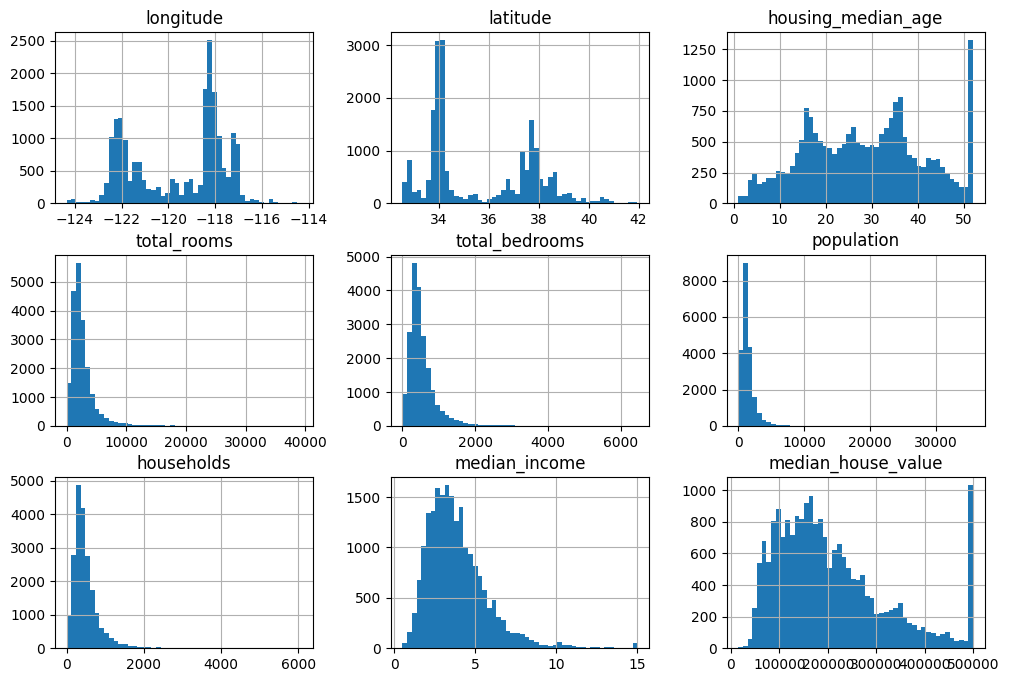

In [ ]:
import matplotlib.pyplot as plt

housing.hist(bins=50, figsize=(12,8))
plt.show()

## Create a Test Set
- Typically 20% of the dataset (or less if the dataset is very large)

### Simple Split
- Re-running the program will generate different test set
- The model will get to see the whole dataset over time (test set becoming training set after re-running), aka data leakage
- This spliting method only works if the dataset is static and test set is separated into another folder

In [ ]:
import numpy as np

def shuffle_and_split_data(data, test_ratio):
  shuffled_indices = np.random.permutation(len(data))
  test_set_size = int(len(data) * test_ratio)
  test_indices = shuffled_indices[:test_set_size]
  train_indices = shuffled_indices[test_set_size:]

  return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set  = shuffle_and_split_data(housing, 0.2)

print(len(train_set), len(test_set))

16512 4128


### Random Seed
- If new data is added, re-running will shuffle the test set, old instances can move from train → test or test → train.
- Only work if the dataset is static

In [ ]:
# Add before np.random.permutation()
# np.random.seed(42)


# ===================================================
# Example

X = np.arange(10)  # [0, 1, 2, ..., 9]

# Comment/Uncomment the following and rerun
np.random.seed(42)

# Get a random permutation of indices
perm = np.random.permutation(len(X))

# Split 80% train / 20% test
split = int(0.8 * len(X))
train_idx, test_idx = perm[:split], perm[split:]

X_train, X_test = X[train_idx], X[test_idx]

print("Train:", X_train)
print("Test:", X_test)

# ===================================================

Train: [8 1 5 0 7 2 9 4]
Test: [3 6]


### Hash-Based

- `crc32` is a 32-bit unsigned integer with output always in:

$$
0 ≤ crc32(index) ≤ 2^{32} - 1
$$

- The output of sequential numbers produce “random-looking” outputs
  ```
  for i in range(10):
    print(crc32(np.int64(i)))

  Output:
  1696784233
  2844319735
  654825492
  3954038922
  3781742995
  767742221
  2739787502
  1877464688
  3066545372
  2054014018
  ```



In [ ]:
from zlib import crc32

def is_id_in_test_set(identifier, test_ratio):
  return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
  ids = data[id_column]
  in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))

  return data.loc[~in_test_set], data.loc[in_test_set]

# Adds an `index` column
housing_with_id = housing.reset_index()

train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")

- If using index as the unique identifier, make sure new data gets appended to the end of the dataset and no row ever gets deleted
- If it is not possible, use the most stable features to build the unique identifier

In [ ]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "id")

- `train_test_split` is a Scikit-Learn function that does similar function to `shuffle_and_split_data()` defined earlier, but with additional features
- `random_state` parameter allows for random generator seed input
- Same test set will be split everytime, provided that the dataset remains static

In [ ]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

### Stratified Sampling

- Stratified sampling is a probability sampling technique that involves dividing a population into homogeneous subgroups, or "strata," based on shared characteristics like age or gender
- So far all the methods above are randomly sampled, which is fine if the dataset is large enough
- If it is not, there is risk of significant sampling bias

- eg. If the median income is very important attribute to predict median housing prices, it is crucial to ensure that the test set is representative of the various categories of incomes in the whole dataset
- `pd.cut()` function converts a continuous variable into categorical bins

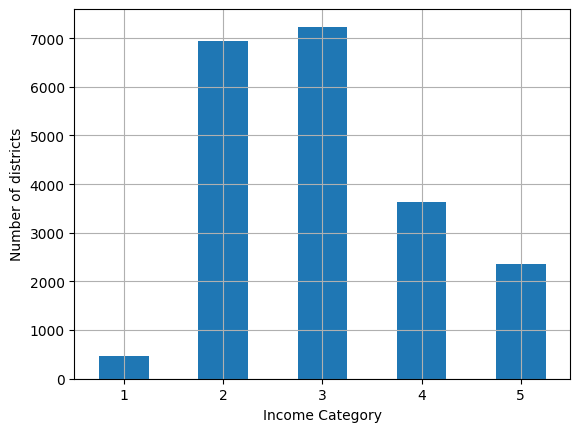

In [ ]:
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0., 1.3, 3.0, 4.5, 6.0, np.inf], labels=[1, 2, 3, 4, 5])

housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income Category")
plt.ylabel("Number of districts")
plt.show()

- With `n_splits=10` and 5 categories, we get 10 train/test pairs total
- Each of the 10 test/train splits contains all 5 categories, in approximately the same proportion
- Multiple splits will be discussed more in cross-validation later

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []

for train_index, test_index in splitter.split(housing, housing["income_cat"]):
  strat_train_set_n = housing.iloc[train_index]
  strat_test_set_n = housing.iloc[test_index]
  strat_splits.append([strat_train_set_n, strat_test_set_n])

In [ ]:
strat_train_set, strat_test_set = strat_splits[0]

Shorter way to get a single split using the `train_test_split()` function with the stratify argument  

In [ ]:
strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

# Print income category proportions
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

,count
income_cat,
3,0.350533
2,0.336483
4,0.176357
5,0.114341
1,0.022287


In [ ]:
# Remove `income_cat` column, reverting data back to its original state

for set_ in (strat_train_set, strat_test_set):
  set_.drop("income_cat", axis=1, inplace=True)

## Explore and Visualize Data

### Visualizing

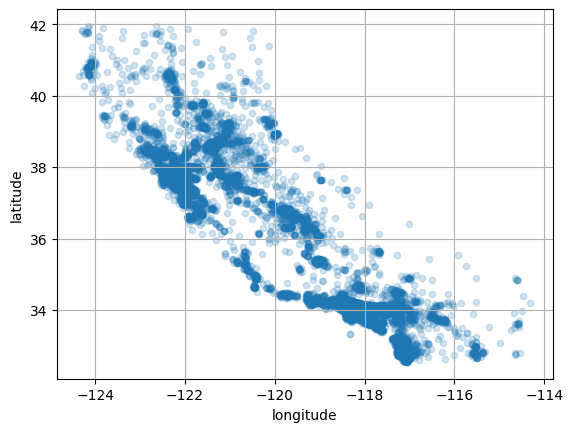

In [ ]:
housing = strat_train_set.copy()

housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)
plt.show()

- Red: Expensive
- Blue: Cheap
- Circle Radius: Population

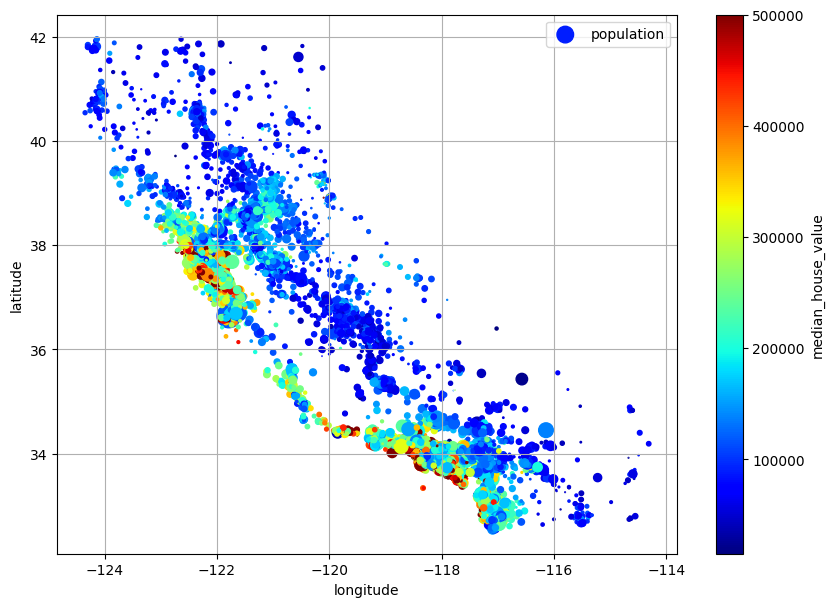

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, s=housing["population"]/100, label="population", c="median_house_value", cmap="jet", colorbar=True, legend=True, sharex=False, figsize=(10,7))
plt.show()

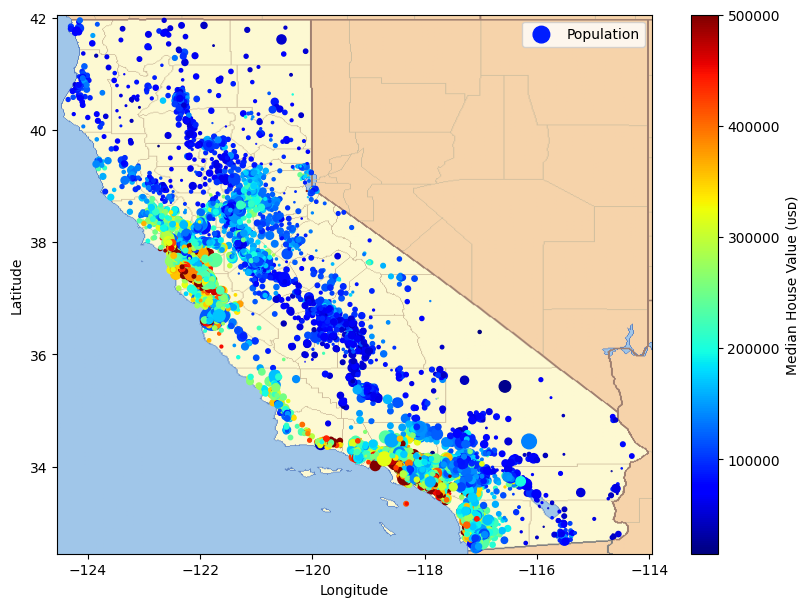

In [ ]:
filename = "california.png"
url = "https://raw.githubusercontent.com/KANGWEII/hands_on_ml/feature-chapter_2/Chapter02/Img/" + filename

# Download directly into current working directory
urllib.request.urlretrieve(url, filename)

housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median House Value (ᴜsᴅ)"})
housing_renamed.plot(
             kind="scatter", x="Longitude", y="Latitude",
             s=housing_renamed["Population"] / 100, label="Population",
             c="Median House Value (ᴜsᴅ)", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))

california_img = plt.imread(filename)
axis = -124.55, -113.95, 32.45, 42.05
plt.axis(axis)
plt.imshow(california_img, extent=axis)
plt.show()

### Look for Correlations

In [ ]:
corr_matrix = housing.drop("ocean_proximity", axis=1).corr()

corr_matrix["median_house_value"].sort_values(ascending=False)

ValueError: could not convert string to float: 'INLAND'